# Evaluation of effect of star and fid plate scale on X-ray events

To look at the impact of the star and fid plate scale update on the position of X-ray events, we reran the aspect pipeline on a set of observations from the `astromon` aspect project.  These observations had already been processed as part of our regular monitoring of celestial location accuracy: all have point-like sources with position matches in other catalogs.  The set of observations was selected to have some of the brighter point-like sources and to also cover the housing temperature range.

We reran the aspect pipeline on the aspect solutions in these Chandra observations using the candidate star and fid plate scale, and then reprojected the X-ray events using the updated aspect solutions, and reran celldetect.  The updated source positions have been compared to the events without the star and fid plate scale update and to the catalog source positions.

The changes that we see in the X-ray events are reasonable and small.  The largest original outlier (obsid 22076) has been explained as a poor initial catalog position, and a better position from SIMBAD has been substituted in for that source.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from glob import glob
from Ska.File import chdir
from Ska.Shell import getenv, bash, tcsh_shell
from astropy.table import Table
from agasc import sphere_dist
from Ska.engarchive import fetch_sci
from kadi import events
from Chandra.Time import DateTime
import matplotlib.pyplot as plt

Here the table that includes the catalog positions of the sources from the astromon project is imported.

In [3]:
astromon = Table.read('plot.rdb')

In [4]:
obsids = [  1001,  1898,  2080,  2549,  2585,  3046,  3048,
            3708,  3716,  4005,  4511,  4759, 5708,  5798,  5839,
            5959,  5979,  6151,   6600,  7302,  9217,  9898,  9933,
            11714, 12115, 12133, 12203, 12236, 12873, 13135, 13136, 13182,
            13637, 13864, 13900, 14397, 14540, 14568, 15765, 16089, 16822,
            17102, 17105, 17351, 17372, 17393, 17735, 18069, 18189, 18365, 18731,
            18732, 19281, 19568, 19692, 19794, 19815, 20789, 21741, 21934,  22076, 22134, 
            22168, 22454, 23000, 23114]

In [5]:
len(obsids)

66

For each observation, calculate the mean of the housing temperature(s) over the observation, get the new and old source positions from celldetect, and compare to the catalog position from the astromon table.

In [ ]:
offsets = {}
for obsid in obsids:
    ds = events.dwells.filter(obsid=obsid)
    start = ds[0].start
    stop = ds[len(ds) - 1].stop
    # Fetch housing temperatures and get the mean of the means
    house = fetch_sci.Msidset(['AACH1T','AAOTALT','AAOTASMT'], start, stop, stat='5min')
    house_temp = np.mean([house['AACH1T'].vals.mean(),
                          house['AAOTALT'].vals.mean(),
                          house['AAOTASMT'].vals.mean()])
    # The src2 file in each of these directories contains the celldetect output.
    # "original" celldetect output using the current plate scale
    orig_src2 = f'{obsid}/orig/src2.fits'
    # "repro" celldetect output using the candidate fid and star plate scale
    repro_src2 = f'{obsid}/repro/src2.fits'
    print(obsid)
    if not os.path.exists(orig_src2):
        print(f"skipping {obsid} in collection")
        continue
    # For each of these source lists, just grab the source with the highest SNR
    orig_sources = Table.read(orig_src2)
    orig_sources.sort('SNR')
    o_src = orig_sources[-1]
    repro_sources = Table.read(repro_src2)
    repro_sources.sort('SNR')
    r_src = repro_sources[-1]
    catalog_sources = astromon[astromon['obsid'] == obsid]
    catalog_sources.sort('snr')
    source = catalog_sources[-1]
    # simbad looks to have more reasonable coords for zeta pup in 22076
    if obsid == 22076:
        source['c_ra'] = 120.89582046
        source['c_dec'] = -40.00305708
    # Find the distance from the catalog source to the original and repro sources.
    # There is no smart-matching here.
    o_offset = 3600 * sphere_dist(o_src['RA'], o_src['DEC'],
                                  source['c_ra'], source['c_dec'])
    r_offset = 3600 * sphere_dist(r_src['RA'], r_src['DEC'],
                                  source['c_ra'], source['c_dec'])
    offsets[obsid] = {
        'obsid': obsid,
        'orig': o_offset,
        'repro': r_offset,
        'orig_snr': o_src['SNR'],
        'repro_snr': r_src['SNR'],
        'c_ra': source['c_ra'],
        'c_dec': source['c_dec'],
        'c_snr': source['snr'],
        'detector': source['detector'],
        'sim_z': source['sim_z'],
        'fids': source['fids'],
        'house_temp': house_temp,
        'date': start,
        'tstart': DateTime(start).secs}

In [7]:
# Re-organize the data into some arrays
times = []
origs = []
repros = []
house_temps = []
obsids = []
for o in offsets.values():
    house_temps.append(o['house_temp'])
    repros.append(o['repro'])
    origs.append(o['orig'])
    times.append(o['tstart'])
    obsids.append(o['obsid'])
times = np.array(times)
origs = np.array(origs)
repros = np.array(repros)
house_temps = np.array(house_temps)

In [8]:
from Ska.Matplotlib import plot_cxctime

The original offsets from the `astromon` source positions are plotted below in blue with the new celldetect-determined source positions in red.

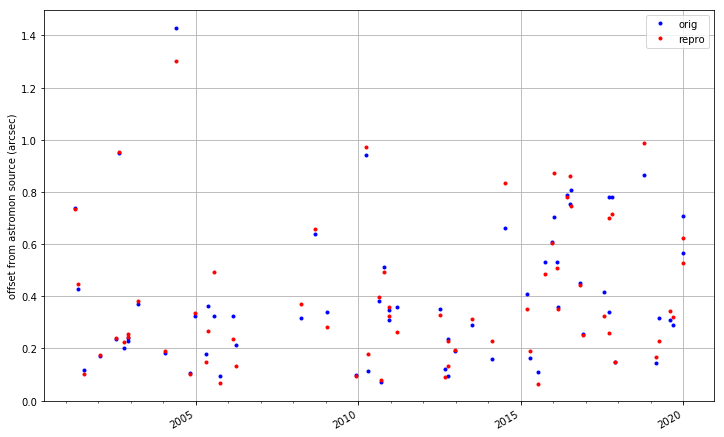

In [9]:
plt.figure(figsize=(12, 8))
plot_cxctime(times, origs, '.', color='blue', label='orig');
plot_cxctime(times, repros, '.', color='red', label='repro');
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('offset from astromon source (arcsec)');

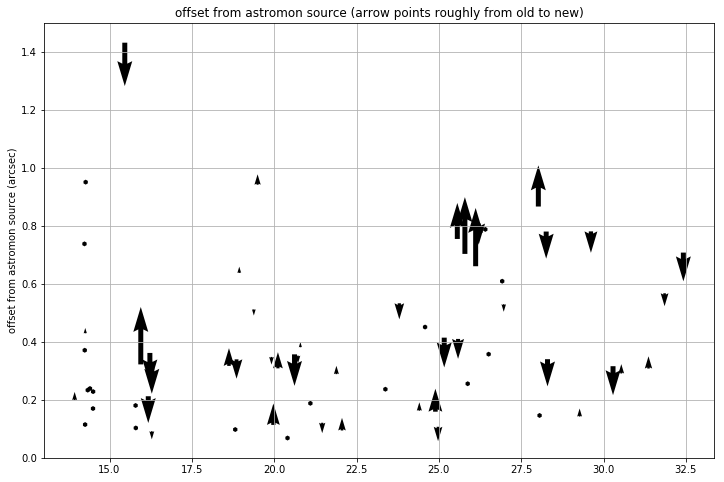

In [10]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.ylabel('offset from astromon source (arcsec)');
plt.quiver(house_temps, origs, np.zeros_like(origs), repros - origs, scale=2)
plt.title('offset from astromon source (arrow points roughly from old to new)')

In [11]:
np.array(obsids)[np.abs(origs - repros) > 0.5]

array([], dtype=int64)

Overall the distribution of changes in the source positions is reasonable for this sample set.

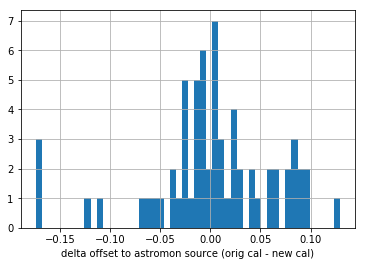

In [12]:
plt.hist(origs - repros, bins=50);
plt.xlabel('delta offset to astromon source (orig cal - new cal)')
plt.grid()